# Population Receptive Field Modeling With Multiple Backends

In [17]:
%load_ext autoreload
%autoreload 2

import os

# Switch between backends
os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "torch"

import keras
import matplotlib.pyplot as plt
import numpy as np

from kerasprf.model.gaussian_2d import Gaussian2DModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we define a 2D grid for our receptive field.

In [18]:
num_steps = 100
x_range, y_range = np.linspace(-5, 5, num_steps), np.linspace(-5, 5, num_steps)
xy_grid, yx_grid = np.meshgrid(x_range, y_range)
grid = np.vstack([xy_grid[None,:,:], yx_grid[None,:,:]]).T
grid.shape

(100, 100, 2)

Next, we create a stimulus that is a time-varying function of the grid.

In [19]:
stimulus = (
    np.ones((num_steps, num_steps, num_steps)) * 
    0.5 * np.sin(np.arange(num_steps)) * 
    (np.sin(grid[:,:,0]) + np.cos(grid[:, :, 1]))
)
stimulus.shape

(100, 100, 100)

Then, we define the pRF response function to simulate a time series. Here, this is the same function as implemented in our pRF model.

In [20]:
def prf_response_fun(x, centroid, sigma):
    return np.exp(-(np.sum((x - centroid)**2, axis=-1) / (2 * sigma**2)))

Now, we simulate a time series by creating pRF predictions for our stimulus and adding noise to them.

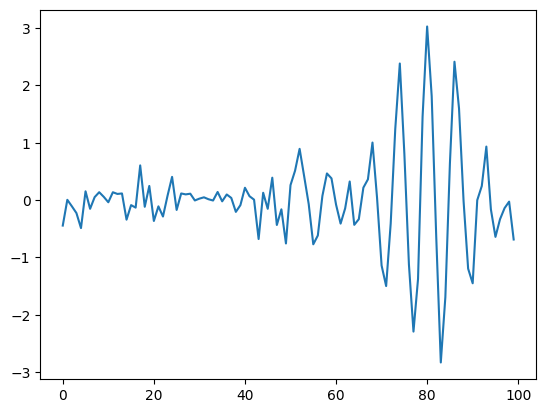

In [21]:
rng = np.random.default_rng(2025)

# True pRF parameters
true_centroid = np.array([-2, 3])
true_sigma = 2
scale = 1000

# pRF predictions
true_signal = (prf_response_fun(grid, true_centroid[None, None, :], true_sigma) * stimulus).sum(axis=(0, 1)) / scale

# Add noise
simulated_signal = true_signal + rng.normal(0, scale=0.2, size=num_steps)

# Visualize
_ = plt.plot(simulated_signal)

We define a loss function to optimize the parameters our pRF model.

In [22]:
# Sum of squares
def loss_fn(y, y_pred):
    return keras.ops.sum((y - y_pred)**2)

We create the pRF model, compile it, and fit it to our grid, stimulus, and simulated time series.

In [23]:
# Define some starting values
start_centroid = np.array([0, 0])
start_sigma = 1

model = Gaussian2DModel(start_centroid, start_sigma, scale)

optimizer = keras.optimizers.Adam(learning_rate=0.1)

optimizer.build(model.trainable_variables)

model.compile(optimizer=optimizer, loss=loss_fn)

model.fit(x=(grid, stimulus), y=simulated_signal)


100%|██████████| 1000/1000 [00:26<00:00, 37.09it/s, loss=5.89]


{'loss': Array(5.894522, dtype=float32)}

We compare the estimated pRF parameters to the true parameters.

In [24]:
model.trainable_variables

[<Variable path=centroid, shape=(2,), dtype=float32, value=[-1.4351612  3.0582826]>,
 <Variable path=sigma, shape=(), dtype=float32, value=1.981003761291504>]

The parameters are reasonably close given that the simulated data is noisy.

We can also plot predictions from the estimated pRF model against predictions from the true pRF model to check the fit.

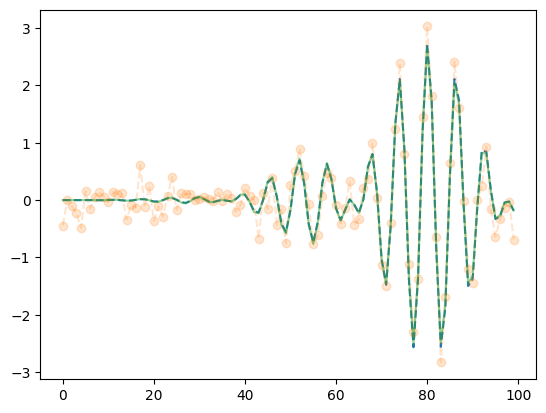

In [25]:
y_pred = model(grid, stimulus, training=False)

fig, ax = plt.subplots(1, 1)

ax.plot(y_pred, "--")
ax.plot(simulated_signal, "--o", alpha=0.2)
ax.plot(true_signal, alpha = 0.5)

The estimated and true predictions are very similar.